# Cross-correlating with LRISb 600

In [15]:
%matplotlib notebook

In [23]:
# imports
from matplotlib import pyplot as plt
import os
import numpy as np

from linetools import utils as ltu

from pypeit import utils
from pypeit.core.wavecal import wvutils

## Load solutions

In [3]:
wfile = os.path.join(os.getenv('PYPEIT_DEV'), 'REDUX_OUT/Keck_LRIS_blue/multi_600_4000_d560', 'MF_keck_lris_blue', 'MasterWaveCalib_A_1_01.json')

In [7]:
wv_dict = ltu.loadjson(wfile)

In [8]:
wv_dict.keys()

dict_keys(['0', '1', '10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9', 'par', 'steps'])

In [12]:
wv_dict['0'].keys()

dict_keys(['cen_disp', 'cen_wave', 'fitc', 'fmax', 'fmin', 'function', 'ions', 'mask', 'nrej', 'nspec', 'pixel_fit', 'rms', 'shift', 'spec', 'tcent', 'wave_fit', 'weights', 'xrej', 'yrej'])

## Plot me the good few

In [10]:
good = [0, 7]

<IPython.core.display.Javascript object>


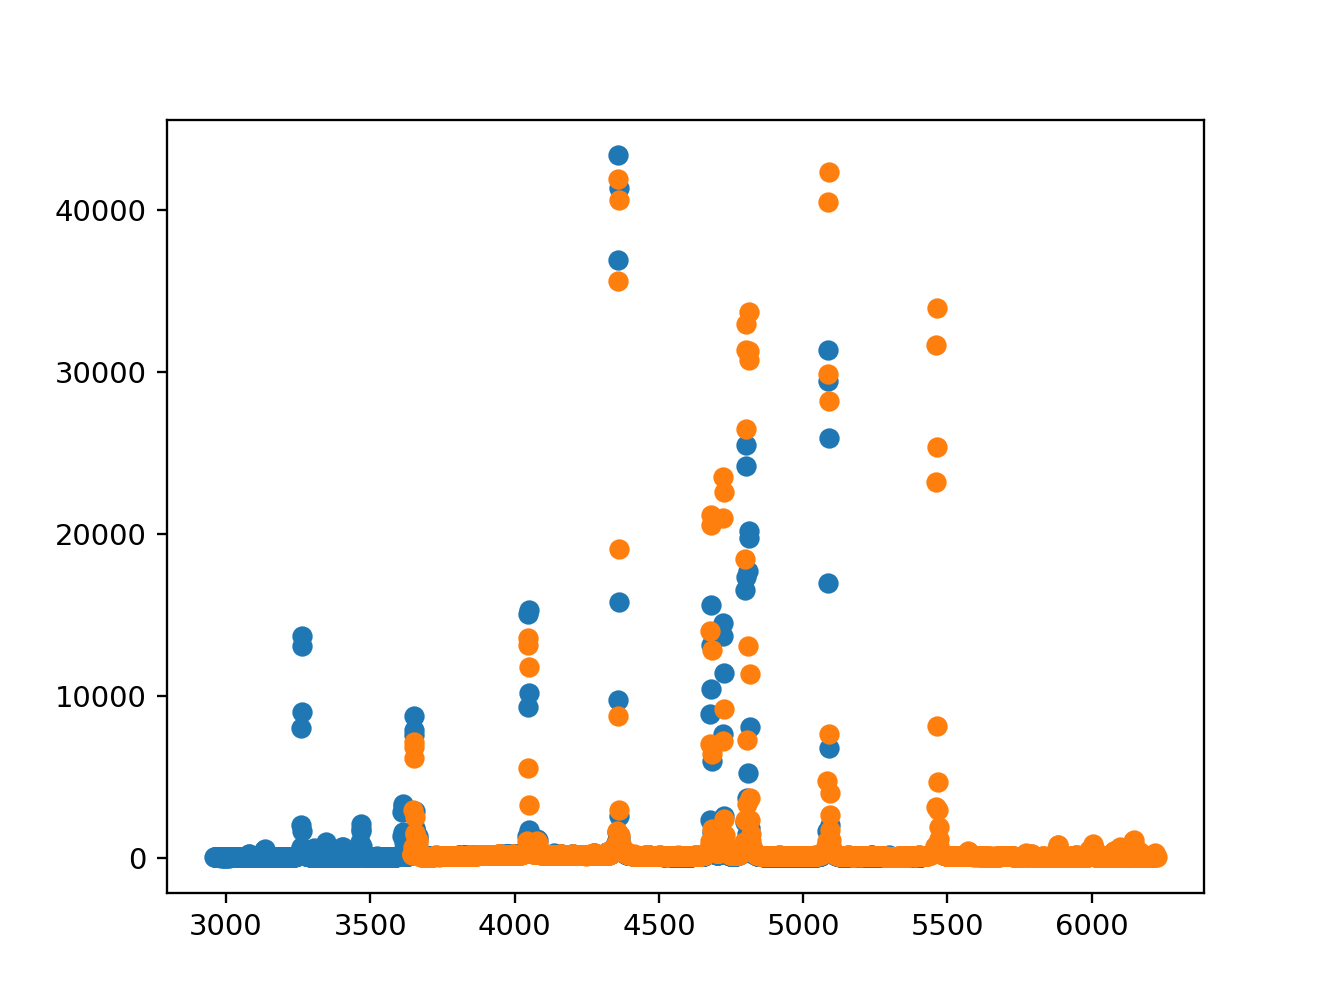

In [17]:
plt.clf()
ax = plt.gca()
# Loop on good
for slit in good:
    iwv_calib = wv_dict[str(slit)]
    x = np.arange(iwv_calib['nspec'])
    tmpwv = utils.func_val(iwv_calib['fitc'], x, iwv_calib['function'],
                                       minx=iwv_calib['fmin'], maxx=iwv_calib['fmax'])
    # Plot
    ax.plot(tmpwv, iwv_calib['spec'], 'o')
#
plt.show()

## Construct

### Dumb cut first -- Need to rebin the 2nd spectrum onto an offset pixel eventually

In [18]:
lcut = 4500.

In [20]:
yvals = []
lvals = []
for kk, slit in enumerate(good):
    iwv_calib = wv_dict[str(slit)]
    x = np.arange(iwv_calib['nspec'])
    tmpwv = utils.func_val(iwv_calib['fitc'], x, iwv_calib['function'],
                                       minx=iwv_calib['fmin'], maxx=iwv_calib['fmax'])
    # 
    if kk == 0:
        gdi = tmpwv < lcut
    else:
        gdi = tmpwv > lcut
    # Save
    yvals.append(np.array(iwv_calib['spec'])[gdi])
    lvals.append(tmpwv[gdi])

In [40]:
nwspec = np.concatenate(yvals)
nwwv = np.concatenate(lvals)
ncomb = nwspec.size
xvals = np.arange(ncomb)

### Try a CC

In [54]:
slit = 0 # Works ok
slit = 2 # Fine
#slit = 9 # Solid
tspec = wv_dict[str(slit)]['spec'] # list
# Pad
pspec = np.zeros_like(nwspec)
nspec = len(tspec)
npad = ncomb - nspec
pspec[npad//2:npad//2+len(tspec)] = tspec

### Can do without stretch

In [55]:
result_out, shift_out, stretch_out, corr_out, shift_cc, corr_cc = wvutils.xcorr_shift_stretch(
    nwspec, pspec)

In [56]:
result_out, shift_out, stretch_out, corr_out, shift_cc, corr_cc

(1,
 204.65071461476902,
 1.0078539652965157,
 0.7709133626987562,
 213.70346729488756,
 0.7416945945390447)

### Check

<IPython.core.display.Javascript object>


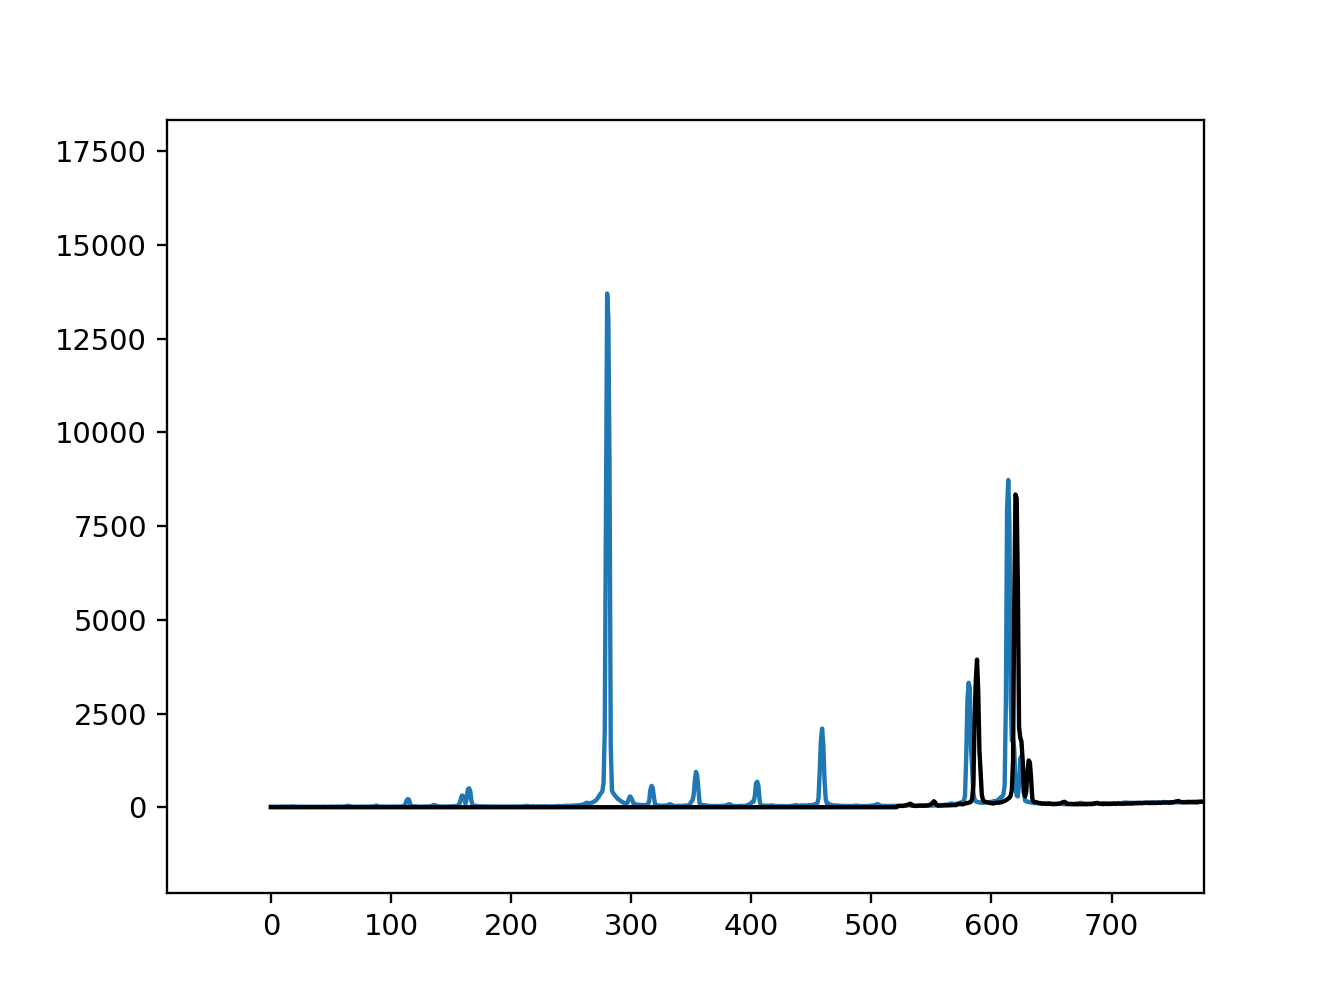

In [58]:
plt.clf()
ax = plt.gca()
#
ax.plot(xvals, nwspec)
ax.plot(xvals, np.roll(pspec, int(shift_cc)), 'k')
plt.show()

<IPython.core.display.Javascript object>


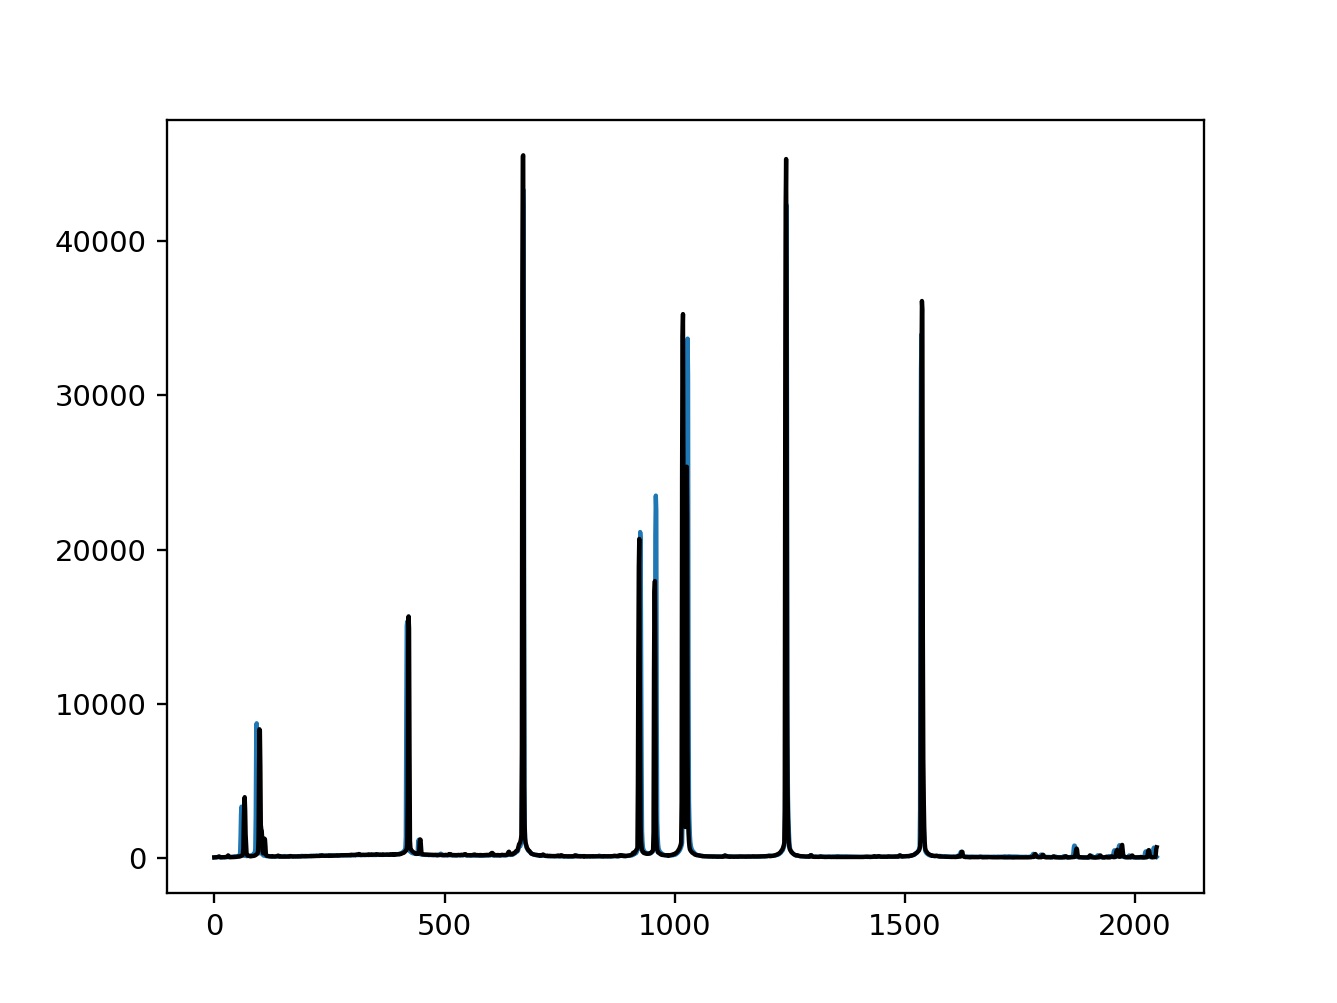

In [62]:
plt.clf()
ax=plt.gca()
i0 = npad//2 + int(shift_cc)
ax.plot(np.arange(nspec), nwspec[i0:i0+nspec])
ax.plot(np.arange(nspec),tspec, 'k')